<a href="https://www.kaggle.com/stiwar1/mlo-autism-eda-preprocessing?scriptVersionId=89281348" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports

In [1]:
import numpy as np
import pandas as pd
pd.set_option('precision', 6)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

import scipy.stats as st
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

SEED = 2311

In [2]:
train = pd.read_csv('../input/autism-prediction/Autism-prediction/train.csv', 
                    index_col='ID', na_values='?', keep_default_na=True)
test = pd.read_csv('../input/autism-prediction/Autism-prediction/test.csv', 
                   index_col='ID', na_values='?', keep_default_na=True)

# Data overview

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1 to 800
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         800 non-null    int64  
 1   A2_Score         800 non-null    int64  
 2   A3_Score         800 non-null    int64  
 3   A4_Score         800 non-null    int64  
 4   A5_Score         800 non-null    int64  
 5   A6_Score         800 non-null    int64  
 6   A7_Score         800 non-null    int64  
 7   A8_Score         800 non-null    int64  
 8   A9_Score         800 non-null    int64  
 9   A10_Score        800 non-null    int64  
 10  age              800 non-null    float64
 11  gender           800 non-null    object 
 12  ethnicity        649 non-null    object 
 13  jaundice         800 non-null    object 
 14  austim           800 non-null    object 
 15  contry_of_res    800 non-null    object 
 16  used_app_before  800 non-null    object 
 17  result          

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         200 non-null    int64  
 1   A2_Score         200 non-null    int64  
 2   A3_Score         200 non-null    int64  
 3   A4_Score         200 non-null    int64  
 4   A5_Score         200 non-null    int64  
 5   A6_Score         200 non-null    int64  
 6   A7_Score         200 non-null    int64  
 7   A8_Score         200 non-null    int64  
 8   A9_Score         200 non-null    int64  
 9   A10_Score        200 non-null    int64  
 10  age              200 non-null    float64
 11  gender           200 non-null    object 
 12  ethnicity        163 non-null    object 
 13  jaundice         200 non-null    object 
 14  austim           200 non-null    object 
 15  contry_of_res    200 non-null    object 
 16  used_app_before  200 non-null    object 
 17  result          

In [5]:
train.rename(columns={'contry_of_res': 'country_res', 'austim': 'autism_in_family'}, inplace=True)
test.rename(columns={'contry_of_res': 'country_res', 'austim': 'autism_in_family'}, inplace=True)

In [6]:
train.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,autism_in_family,country_res,used_app_before,result,age_desc,relation,Class/ASD
ID,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,1,1,1,0,1,1,1,18.605397,f,White-European,no,no,United States,no,7.819715,18 and more,Self,0
2,0,0,0,0,0,0,0,0,0,1,13.829369,f,South Asian,no,no,Australia,no,10.544296,18 and more,NaN,0
3,1,1,1,1,1,1,0,0,1,1,14.679893,f,White-European,no,no,United Kingdom,no,13.167506,18 and more,Self,1
4,0,0,0,1,0,0,0,0,0,0,61.035288,f,South Asian,no,no,New Zealand,no,1.530098,18 and more,NaN,0
5,0,0,0,0,1,0,0,0,1,1,14.256686,m,Black,no,yes,Italy,no,7.949723,18 and more,Self,0


In [7]:
features = list(test.columns)
TARGET = 'Class/ASD'

In [8]:
train[features].nunique()

A1_Score              2
A2_Score              2
A3_Score              2
A4_Score              2
A5_Score              2
A6_Score              2
A7_Score              2
A8_Score              2
A9_Score              2
A10_Score             2
age                 800
gender                2
ethnicity            11
jaundice              2
autism_in_family      2
country_res          61
used_app_before       2
result              800
age_desc              1
relation              5
dtype: int64

In [9]:
num_features = ['age', 'result']
cat_features = [f for f in features if f not in num_features]

# Categorical features

Utility functions for visualizations:

In [10]:
def plot_grouped(col, order, train):
    '''
    Displays countplot of feature (col) grouped by target column (Class/ASD).
    '''
    ax = sns.countplot(x=col, data=train, order=order, hue=TARGET)
    ax.set_title('\'' + col + '\' distribution grouped by ASD diagnosis', fontsize=15, fontweight='bold')
    ax.set_xlabel(col, fontsize=10, fontweight='bold')
    ax.set_ylabel('count', fontsize=10, fontweight='bold')
    #value counts at the top of histograms
    for p in ax.patches:
        ax.text((p.get_x() + p.get_width()/2), (p.get_height() + 0.5), p.get_height(), 
                horizontalalignment='center', fontsize=10)
    plt.show()

In [11]:
def plot_comparison(col, order, train, test):
    '''
    Displays countplot of feature (col) in train and test datasets for comparison.
    '''
    plt.suptitle('\'' + col + '\' distribution in datasets', fontsize=15, fontweight='bold')

    sns.countplot(x=col, data=train, order=order, ax=ax[0])
    ax[0].set_title('Train data', fontsize=12, fontweight='bold')
    for p in ax[0].patches:
        ax[0].text((p.get_x() + p.get_width()/2), (p.get_height() + 0.5), p.get_height(), 
                   horizontalalignment='center', fontsize=10)
    ax[0].set_xlabel(col, fontsize=10, fontweight='bold')
    ax[0].set_ylabel('count', fontsize=10, fontweight='bold')

    sns.countplot(x=col, data=test, order=order, ax=ax[1])
    ax[1].set_title('Test data', fontsize=12, fontweight='bold')
    for p in ax[1].patches:
        ax[1].text((p.get_x() + p.get_width()/2), (p.get_height() + 0.5), p.get_height(), 
                   horizontalalignment='center', fontsize=10)
    ax[1].set_xlabel(col, fontsize=10, fontweight='bold')
    ax[1].set_ylabel('count', fontsize=10, fontweight='bold')

    fig.tight_layout()
    plt.show()

### gender

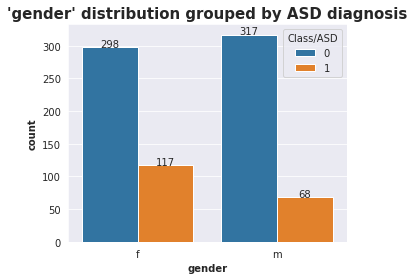

In [12]:
plt.figure(figsize=(5, 4))
plot_grouped('gender', ['f', 'm'], train)

Higher proportion of ASD in females.

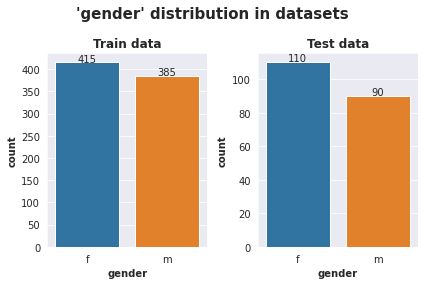

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,4))
plot_comparison('gender', ['f', 'm'], train, test)

Similar distributions in both datasets.

In [14]:
gender_mapping = {'f': 0, 'm': 1}

train['gender'] = train.gender.map(gender_mapping)
test['gender'] = test.gender.map(gender_mapping)

### ethnicity

In [15]:
train.ethnicity.unique()

array(['White-European', 'South Asian', 'Black', 'Asian',
       'Middle Eastern ', nan, 'others', 'Latino', 'Turkish', 'Others',
       'Hispanic', 'Pasifika'], dtype=object)

Cleaning up repeated categories:

In [16]:
train['ethnicity'] = train.ethnicity.map({'others': 'Others'}).fillna(train.ethnicity)
test['ethnicity'] = test.ethnicity.map({'others': 'Others'}).fillna(train.ethnicity)

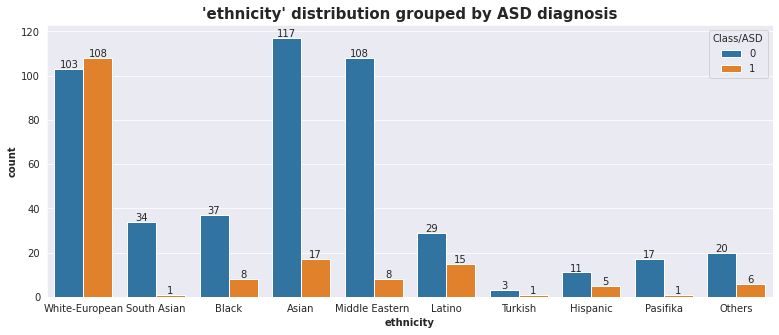

In [17]:
eth_order = ['White-European', 'South Asian', 'Black', 'Asian', 'Middle Eastern ',
             'Latino', 'Turkish', 'Hispanic', 'Pasifika', 'Others']

plt.figure(figsize=(13,5))
plot_grouped('ethnicity', eth_order, train)

Significantly higher proportion of ASD in White-Europeans as compared to other ethnicities.

Filling in missing values as 'Others' since we don't know the ethnicity either way.

In [18]:
train_filled = train.copy()
train_filled.ethnicity.fillna('Others', inplace=True)

test_filled = test.copy()
test_filled.ethnicity.fillna('Others', inplace=True)

Distribution after filling missing values:

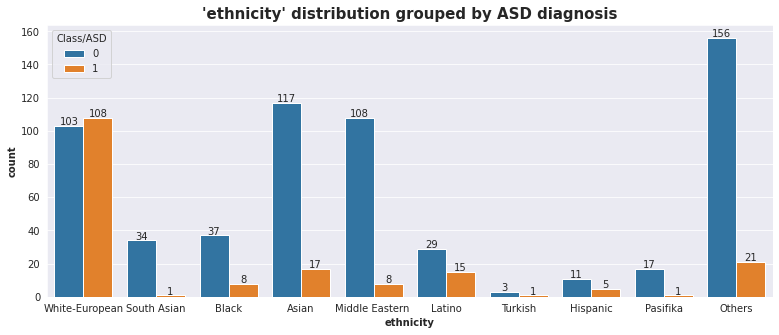

In [19]:
plt.figure(figsize=(13,5))
plot_grouped('ethnicity', eth_order, train_filled)

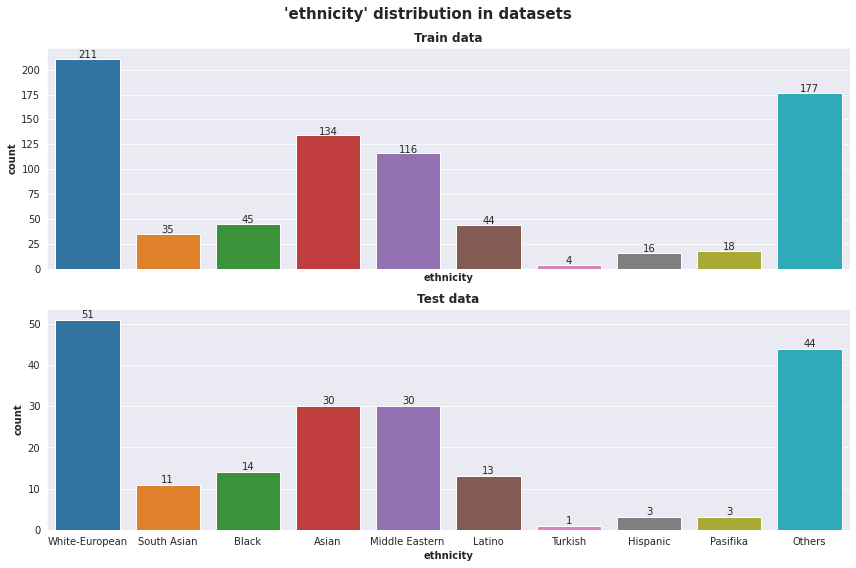

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)
plot_comparison('ethnicity', eth_order, train_filled, test_filled)

In [21]:
ethnicity_mapping = dict(zip(eth_order, np.arange(10)))

train['ethnicity'] = train.ethnicity.map(ethnicity_mapping).fillna(train.ethnicity)
test['ethnicity'] = test.ethnicity.map(ethnicity_mapping).fillna(test.ethnicity)
train_filled['ethnicity'] = train_filled.ethnicity.map(ethnicity_mapping)
test_filled['ethnicity'] = test_filled.ethnicity.map(ethnicity_mapping)

### jaundice

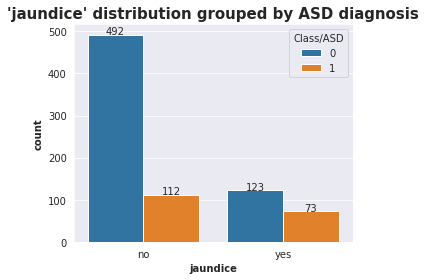

In [22]:
plt.figure(figsize=(5,4))
plot_grouped('jaundice', ['no', 'yes'], train)

Higher proportion of ASD cases for patients who suffered with jaundice at birth.

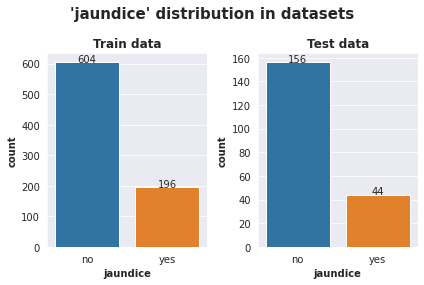

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,4))
plot_comparison('jaundice', ['no', 'yes'], train, test)

Similar distributions in both datasets.

### autism_in_family

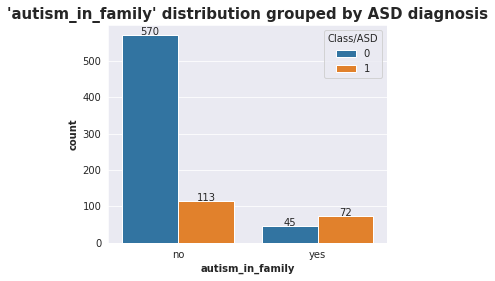

In [24]:
plt.figure(figsize=(5,4))
plot_grouped('autism_in_family', ['no', 'yes'], train)

We can see a significant increase in proportion of ASD cases when there is a family history of ASD.

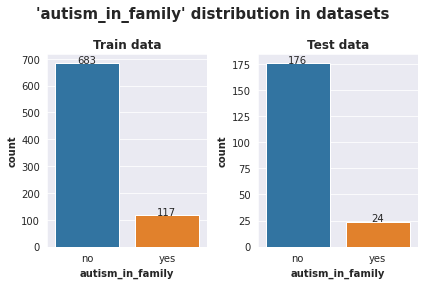

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,4))
plot_comparison('autism_in_family', ['no', 'yes'], train, test)

Similar distributions in both datasets.

### used_app_before

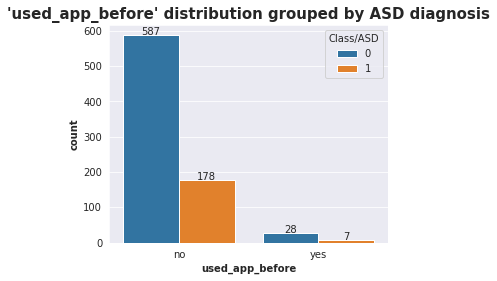

In [26]:
plt.figure(figsize=(5,4))
plot_grouped('used_app_before', ['no', 'yes'], train)

Repeat users are very few.  
Moreover, there is no significant change in proportion of ASD diagnosis between new and repeat users.

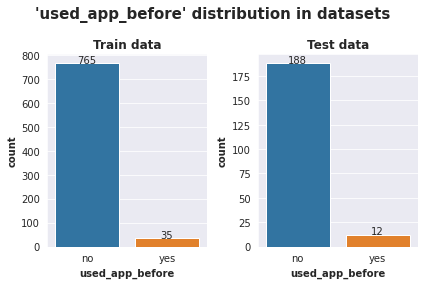

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,4))
plot_comparison('used_app_before', ['no', 'yes'], train, test)

Similar distributions in both datasets.

In [28]:
binary_mapping = {'no': 0, 'yes': 1}

for col in ['jaundice', 'autism_in_family', 'used_app_before']:
    train[col] = train[col].map(binary_mapping)
    test[col] = test[col].map(binary_mapping)
    train_filled[col] = train_filled[col].map(binary_mapping)
    test_filled[col] = test_filled[col].map(binary_mapping)

### age_desc

In [29]:
train['age_desc'].nunique(), test['age_desc'].nunique()

(1, 1)

Only one unique value in both datasets. We can drop this column.

In [30]:
train.drop(['age_desc'], axis=1, inplace=True)
test.drop(['age_desc'], axis=1, inplace=True)

train_filled.drop(['age_desc'], axis=1, inplace=True)
test_filled.drop(['age_desc'], axis=1, inplace=True)

In [31]:
features.remove('age_desc')
cat_features.remove('age_desc')

### relation

In [32]:
train.relation.unique()

array(['Self', nan, 'Health care professional', 'Parent', 'Relative',
       'Others'], dtype=object)

We can fill the missing values with 'Others'.

In [33]:
train_filled.relation.fillna('Others', inplace=True)
test_filled.relation.fillna('Others', inplace=True)

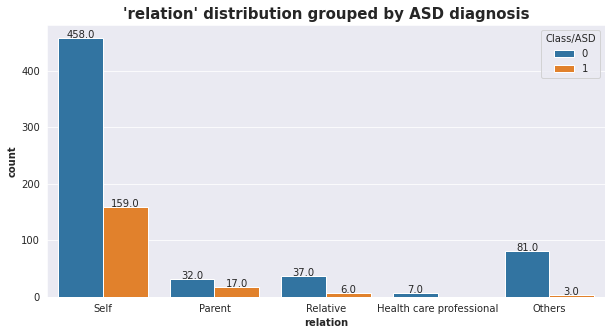

In [34]:
rel_order = ['Self', 'Parent', 'Relative', 'Health care professional', 'Others']

plt.figure(figsize=(10, 5))
plot_grouped('relation', rel_order, train_filled)

Most of the responses were filled in by the person themselves. The other categories do not show any significant changes in proportion of cases.  
It is interesting that responses filled by a healthcare professional on someone's behalf are actually all negative cases. One would expect that people reaching the stage of getting medical help would have higher chances of positive diagnosis. However, the number is very small so we cannot extrapolate from there.

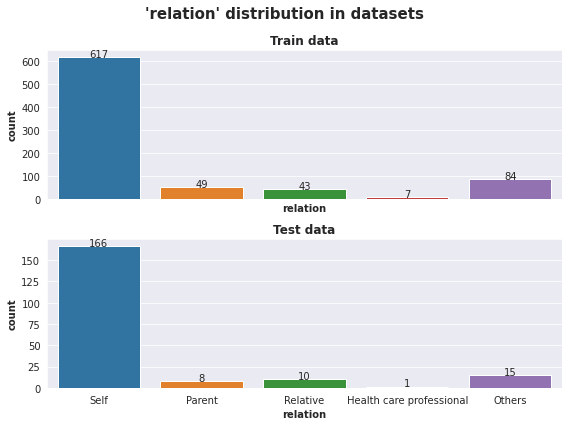

In [35]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)
plot_comparison('relation', rel_order, train_filled, test_filled)

Similar distributions but very skewed in favour of one category.

In [36]:
relation_mapping = {
    'Self': 0, 
    'Parent': 1,
    'Relative': 2, 
    'Health care professional': 3, 
    'Others': 4
}

train['relation'] = train['relation'].map(relation_mapping)
test['relation'] = test['relation'].map(relation_mapping)
train_filled['relation'] = train_filled['relation'].map(relation_mapping)
test_filled['relation'] = test_filled['relation'].map(relation_mapping)

### country_res

In [37]:
train['country_res'].nunique(), test['country_res'].nunique()

(61, 44)

In [38]:
set(test['country_res'].unique()) - set(train['country_res'].unique())

{'Burundi', 'Lebanon'}

Two extra countries in test set.

In [39]:
train['country_res'].value_counts().values

array([148,  94,  93,  74,  58,  43,  40,  23,  16,  15,  14,  12,  12,
        11,   9,   9,   7,   6,   6,   6,   6,   5,   5,   5,   5,   5,
         4,   4,   4,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1])

Some countries have a large number of people participating while several countries have only one participant.  
We can combine the countries with low participation to reduce cardinality.

In [40]:
country_counts = train['country_res'].value_counts().to_frame()
high_counts = country_counts[country_counts.country_res > 20].index.to_list()
high_counts

['United States',
 'United Arab Emirates',
 'New Zealand',
 'India',
 'United Kingdom',
 'Australia',
 'Jordan',
 'Afghanistan']

In [41]:
def country_mapping(country):
    high_counts = {'United States', 'United Arab Emirates', 'New Zealand', 'India', 
                   'United Kingdom', 'Australia', 'Jordan', 'Afghanistan'}
    
    encoding = dict(zip(high_counts, np.arange(1, 9)))
    
    if country in high_counts:
        return encoding[country]
    else:
        return 0

In [42]:
train['country_res'] = train.country_res.apply(country_mapping)
test['country_res'] = test.country_res.apply(country_mapping)
train_filled['country_res'] = train_filled.country_res.apply(country_mapping)
test_filled['country_res'] = test_filled.country_res.apply(country_mapping)

### A\*_Scores

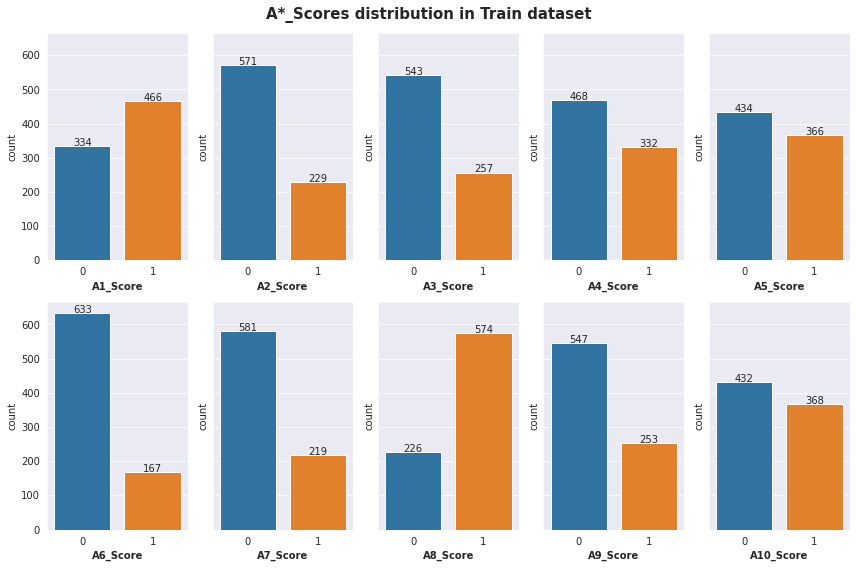

In [43]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 8), sharey=True)
plt.suptitle('A*_Scores distribution in Train dataset', fontsize=15, fontweight='bold')
k = 0
for i in range(2):
    for j in range(5):
        k += 1
        col = 'A' + str(k) + '_Score'
        
        sns.countplot(x=col, data=train, order=[0, 1], ax=ax[i][j])
        ax[i][j].set_xlabel(col, fontsize=10, fontweight='bold')
        for p in ax[i][j].patches:
            ax[i][j].text((p.get_x() + p.get_width()/2), (p.get_height() + 0.5), p.get_height(), 
                          horizontalalignment='center', fontsize=10)
            
fig.tight_layout()

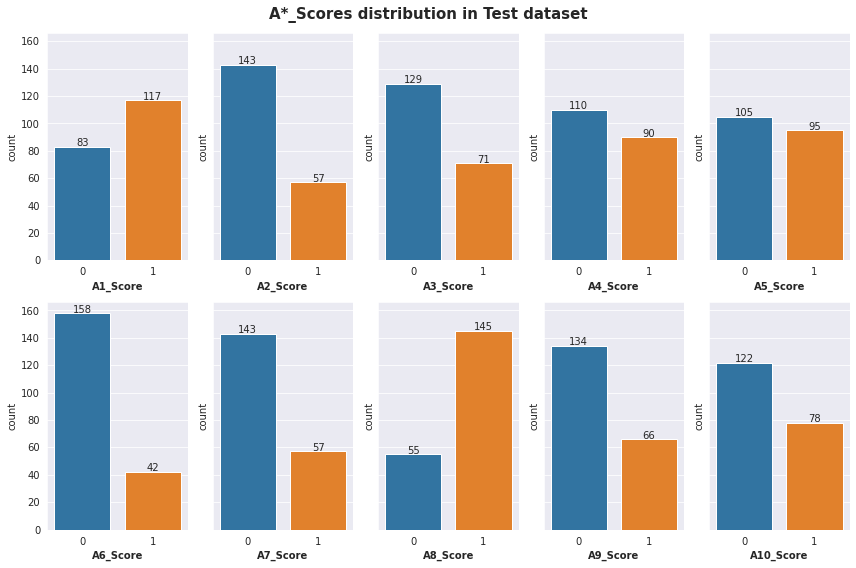

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 8), sharey=True)
plt.suptitle('A*_Scores distribution in Test dataset', fontsize=15, fontweight='bold')
k = 0
for i in range(2):
    for j in range(5):
        k += 1
        col = 'A' + str(k) + '_Score'
        
        sns.countplot(x=col, data=test, order=[0, 1], ax=ax[i][j])
        ax[i][j].set_xlabel(col, fontsize=10, fontweight='bold')
        for p in ax[i][j].patches:
            ax[i][j].text((p.get_x() + p.get_width()/2), (p.get_height() + 0.5), p.get_height(), 
                          horizontalalignment='center', fontsize=10)
            
fig.tight_layout()

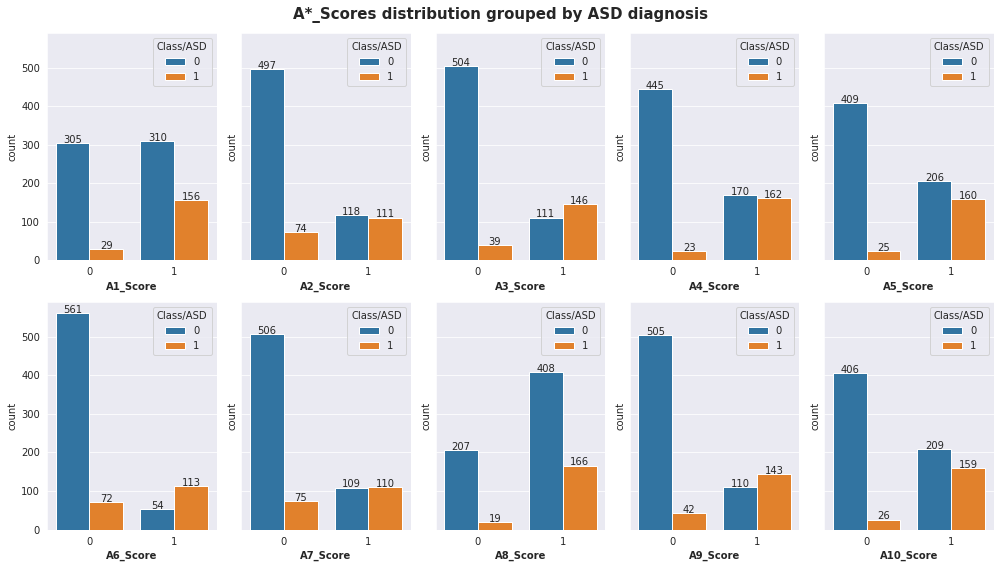

In [45]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(14, 8), sharey=True)
plt.suptitle('A*_Scores distribution grouped by ASD diagnosis', fontsize=15, fontweight='bold')
k = 0
for i in range(2):
    for j in range(5):
        k += 1
        col = 'A' + str(k) + '_Score'
        
        sns.countplot(x=col, data=train, order=[0, 1], hue=TARGET, ax=ax[i][j])
        ax[i][j].set_xlabel(col, fontsize=10, fontweight='bold')
        for p in ax[i][j].patches:
            ax[i][j].text((p.get_x() + p.get_width()/2), (p.get_height() + 0.5), p.get_height(), 
                          horizontalalignment='center', fontsize=10)
            
fig.tight_layout()

A1_Score and A8_Score seem less correlated with the target, as compared to the other eight scores.  
However, they still show significant change in proportion corresponding with the target.

# Numerical features

### result

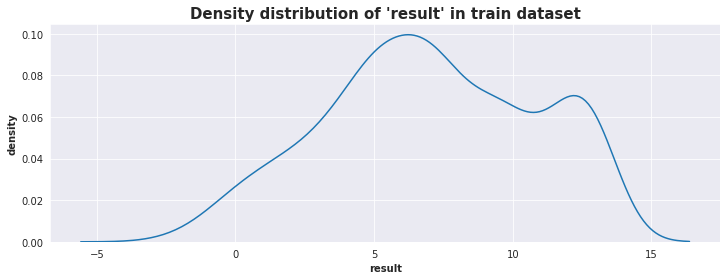

In [46]:
plt.figure(figsize=(12,4))
ax = sns.kdeplot(x='result', data=train)
ax.set_title('Density distribution of \'result\' in train dataset', fontsize=15, fontweight='bold')
ax.set_xlabel('result', fontsize=10, fontweight='bold')
ax.set_ylabel('density', fontsize=10, fontweight='bold')
plt.show()

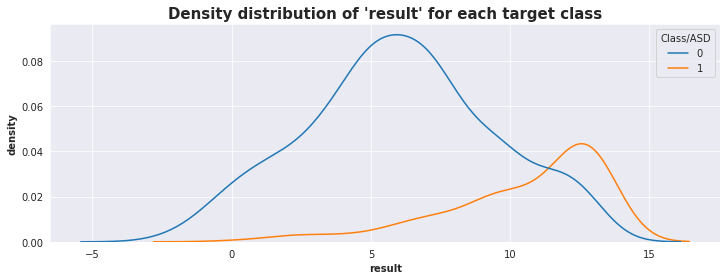

In [47]:
plt.figure(figsize=(12,4))
ax = sns.kdeplot(x='result', data=train, hue=TARGET)
ax.set_title('Density distribution of \'result\' for each target class', fontsize=15, fontweight='bold')
ax.set_xlabel('result', fontsize=10, fontweight='bold')
ax.set_ylabel('density', fontsize=10, fontweight='bold')
plt.show()

The density distribution of *result* separates into two distinct distributions based on target class.  
Negative class has a peak around 5 to 6, while the positive class has its peak around 12 to 13. The positive class peak is smaller because there are fewer positive class observations in the dataset overall, hence the density is lower. But the clear distinction between the two distributions indicates that result is a useful feature for prediction the target.

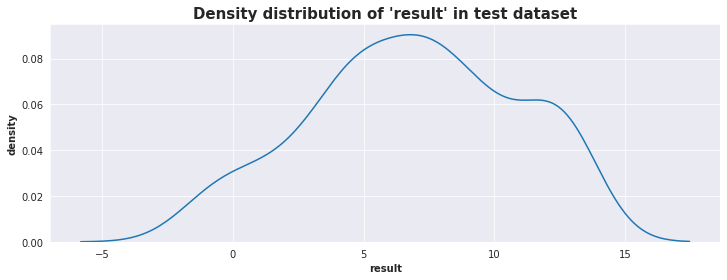

In [48]:
plt.figure(figsize=(12,4))
ax = sns.kdeplot(x='result', data=test)
ax.set_title('Density distribution of \'result\' in test dataset', fontsize=15, fontweight='bold')
ax.set_xlabel('result', fontsize=10, fontweight='bold')
ax.set_ylabel('density', fontsize=10, fontweight='bold')
plt.show()

Similar distribution with two peaks for the two target classes, but slightly less distinct compared to the train dataset.

### age

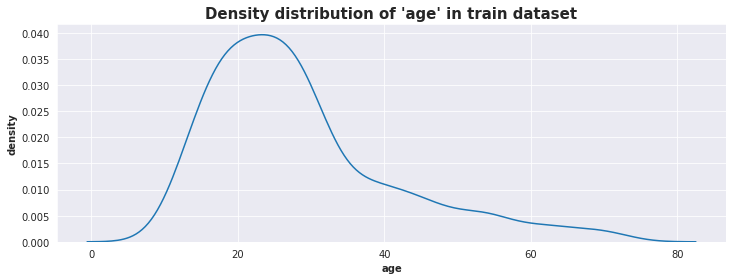

In [49]:
plt.figure(figsize=(12,4))
ax = sns.kdeplot(x='age', data=train)
ax.set_title('Density distribution of \'age\' in train dataset', fontsize=15, fontweight='bold')
ax.set_xlabel('age', fontsize=10, fontweight='bold')
ax.set_ylabel('density', fontsize=10, fontweight='bold')
plt.show()

A majority of the survey participants are around the age of 18-25. 

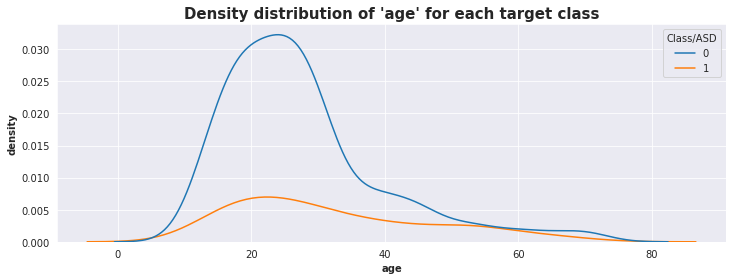

In [50]:
plt.figure(figsize=(12,4))
ax = sns.kdeplot(x='age', data=train, hue=TARGET)
ax.set_title('Density distribution of \'age\' for each target class', fontsize=15, fontweight='bold')
ax.set_xlabel('age', fontsize=10, fontweight='bold')
ax.set_ylabel('density', fontsize=10, fontweight='bold')
plt.show()

Unlike *result*, *age* does not show any change in distribution for different target classes.

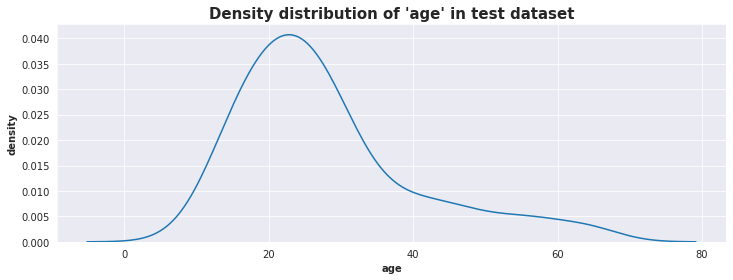

In [51]:
plt.figure(figsize=(12,4))
ax = sns.kdeplot(x='age', data=test)
ax.set_title('Density distribution of \'age\' in test dataset', fontsize=15, fontweight='bold')
ax.set_xlabel('age', fontsize=10, fontweight='bold')
ax.set_ylabel('density', fontsize=10, fontweight='bold')
plt.show()

Similar distribution, but not likely to be informative.

# Feature selection

### Chi-squared test of independence (categorical-categorical)

In [52]:
independence_test = chi2(train_filled[cat_features], train_filled[TARGET])
display(pd.DataFrame(data={'chi2': independence_test[0], 
                           'p-value': independence_test[1]}, 
                     index=cat_features))

,chi2,p-value
A1_Score,28.087740,1.159380e-07
A2_Score,82.757731,9.275235e-20
A3_Score,164.029628,1.490354e-37
A4_Score,123.063444,1.350604e-28
A5_Score,87.289627,9.373823e-21
A6_Score,186.356096,1.984980e-42
A7_Score,90.494446,1.854969e-21
A8_Score,10.842539,9.919460e-04
A9_Score,158.731010,2.142467e-36
A10_Score,83.478414,6.441553e-20


* As expected, target variable is more independent from *A1_Score* and *A8_Score* as compared to the other A\*_Scores, but they are still significant compared to other features.
*  target variable is independent from *used_app_before* and *country_res*.
* *gender* is also a candidate for removal, but we will check mutual information scores before deciding.

### T-test (continuous-categorical)

In [53]:
st.ttest_ind(train_filled['age'], train_filled[TARGET])

Ttest_indResult(statistic=62.32779968540197, pvalue=0.0)

In [54]:
st.ttest_ind(train_filled['result'], train_filled[TARGET])

Ttest_indResult(statistic=50.65191227125563, pvalue=0.0)

### ANOVA-F test (continuous-categorical)

In [55]:
anova_test = f_classif(train_filled[num_features], train_filled[TARGET])
display(pd.DataFrame(data={'f-statistic': anova_test[0], 
                           'p-value': anova_test[1]}, 
                     index=num_features))

,f-statistic,p-value
age,17.472145,3.237871e-05
result,260.607789,6.072736e-51


### Mutual Information

In [56]:
cat_mask = [f in cat_features for f in features] #boolean mask for discrete features
mi_scores = mutual_info_classif(train_filled[features], train[TARGET], discrete_features=cat_mask, random_state=SEED)
display(pd.DataFrame(data={'mi_score': mi_scores}, index=features))

,mi_score
A1_Score,0.046220
A2_Score,0.067266
A3_Score,0.145756
A4_Score,0.138592
A5_Score,0.107766
A6_Score,0.129083
A7_Score,0.071685
A8_Score,0.027725
A9_Score,0.139086
A10_Score,0.103356


**Based on our tests, we will drop *'used_app_before'* from our dataset.**

In [57]:
train_filled.drop(['used_app_before'], axis=1, inplace=True)
test_filled.drop(['used_app_before'], axis=1, inplace=True)

In [58]:
important_features = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score',
                      'A8_Score', 'A9_Score', 'A10_Score', 'result', 'ethnicity', 'autism_in_family']

# Processed dataset

In [59]:
train_filled.to_csv('train_proc.csv', index=False)
test_filled.to_csv('test_proc.csv', index=False)